# Library Import

In [1]:
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score)
import matplotlib.pyplot as plt

# Load Data

t: time  
f: failures  
cum_f: cumulative failures

In [2]:
data = np.loadtxt('J2.csv', delimiter=',', skiprows=1, dtype=int)
data = np.insert(data, 0, [0, 0, 0], axis=0)

In [3]:
t = data[:, 0]
f = data[:, 1]
cum_f = data[:, 2]

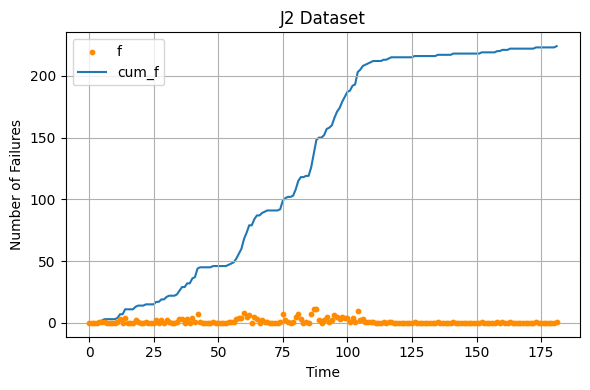

In [4]:
plt.figure(figsize=(6, 4))

plt.scatter(t, f, color='darkorange', s=10, label='f', zorder=2)
plt.plot(t, cum_f, label='cum_f', zorder=1)

plt.title('J2 Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Estimation

Preparation functions for parameter estimation

In [5]:
tiny = np.finfo(float).tiny  # Prevent log calculation errors (avoid log(0))


# Inflection S-Shape model function
def inflection_s(t, a, b, c):
    return a * (1 - np.exp(-b * t)) / (1 + c * np.exp(-b * t))


# Residual function for LSM estimation using Inflection S-Shape model
def inflection_s_lsm(params, t, cum_f):
    a, b, c = params
    return inflection_s(t, a, b, c) - cum_f


# Function to estimate parameter 'a' of the Inflection S-Shape model
def inflection_s_a(t, f, b, c):
    a = f * (1 + c * np.exp(-b * t)) / (1 - np.exp(-b * t))
    return a


# Negative log-likelihood function for the Inflection S-Shape model
def inflection_s_nll(params, t, f):
    b, c = params
    a = np.sum(f) * (1 + c * np.exp(-b * t[-1])) / (1 - np.exp(-b * t[-1]))

    term1 = a * ((1 - np.exp(-b * t[1:])) / (1 + c * np.exp(-b * t[1:]))
                 - (1 - np.exp(-b * t[:-1])) / (1 + c * np.exp(-b * t[:-1])))
    term1[term1 < tiny] = tiny
    log_term1 = f[1:] * np.log(term1)

    term2 = a * ((1 - np.exp(-b * t[-1])) / (1 + c * np.exp(-b * t[-1]))
                 - (1 - np.exp(-b * t[0])) / (1 + c * np.exp(-b * t[0])))

    log_facs = [np.sum([np.log(j) for j in range(1, i+1)]) for i in f[1:]]

    loglikelihood = np.sum(log_term1) - term2 - np.sum(log_facs)
    return -loglikelihood

Setup variables for parameter estimation

In [6]:
eps = np.sqrt(np.finfo(float).eps)  # Small epsilon to avoid division by zero

# Parameter initialization and bounds for LSM estimation
lsm_init_guess = [cum_f[-1] * 1.5, 0.1, 1]
lsm_bounds = ([cum_f[-1], eps, 0], [np.inf, np.inf, np.inf])

# Parameter initialization and bounds for MLE estimation
mle_init_guess = [0.1, 1]
mle_bounds = [(eps, np.inf), (0, np.inf)]

## LSM

### Trust Region Reflective algorithm

In [7]:
result = least_squares(inflection_s_lsm, lsm_init_guess, args=(t, cum_f),
                       method='trf', bounds=lsm_bounds)

trf_a, trf_b, trf_c = result.x
print(f'a: {trf_a}, b: {trf_b}, c: {trf_c}')

a: 226.93370835706764, b: 0.05401184489784803, c: 59.62356729487018


In [8]:
f_pred = inflection_s(t, trf_a, trf_b, trf_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 60.57694135481384
RMSE: 7.783118999142557
MAE: 6.144623395641202
MAPE: 31929077724291.27
R2 score: 0.9918422160804236


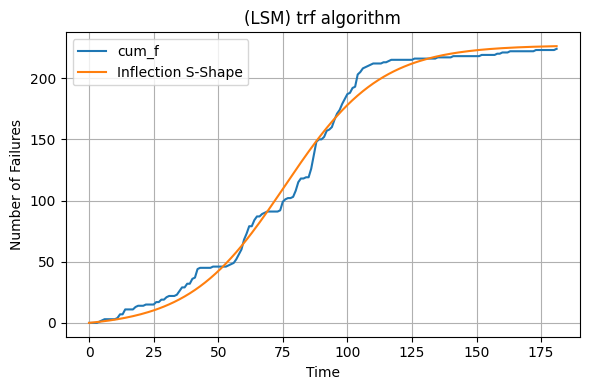

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(LSM) trf algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### dogleg algorithm

In [10]:
result = least_squares(inflection_s_lsm, lsm_init_guess, args=(t, cum_f),
                       method='dogbox', bounds=lsm_bounds)

dogbox_a, dogbox_b, dogbox_c = result.x
print(f'a: {dogbox_a}, b: {dogbox_b}, c: {dogbox_c}')

a: 224.0, b: 0.02533568794068693, c: 3.4199471925912106


In [11]:
f_pred = inflection_s(t, dogbox_a, dogbox_b, dogbox_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 562.518039938341
RMSE: 23.717462763506997
MAE: 21.288236545297767
MAPE: 193712945718405.97
R2 score: 0.9242467427696237


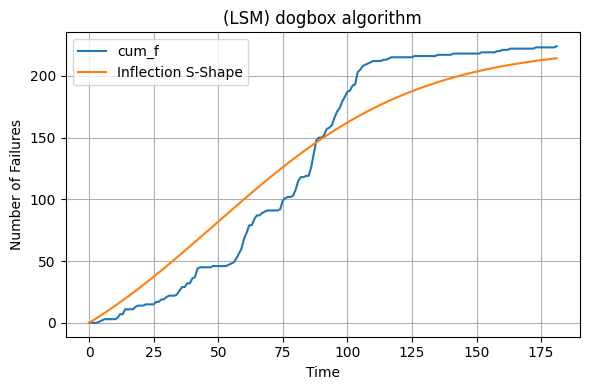

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(LSM) dogbox algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

## MLE

### Nelder-Mead algorithm

In [13]:
result = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='Nelder-Mead', bounds=mle_bounds)

nelder_mead_b, nelder_mead_c = result.x
nelder_mead_a = inflection_s_a(t[-1], np.sum(f), nelder_mead_b, nelder_mead_c)
print(f'a: {nelder_mead_a}, b: {nelder_mead_b}, c: {nelder_mead_c}')

a: 224.79109923605188, b: 0.05343160585597655, c: 54.98476859297252


In [14]:
f_pred = inflection_s(t, nelder_mead_a, nelder_mead_b, nelder_mead_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 62.61064835077829
RMSE: 7.9126890720398135
MAE: 5.806233293545678
MAPE: 33851363276860.727
R2 score: 0.9915683405453147


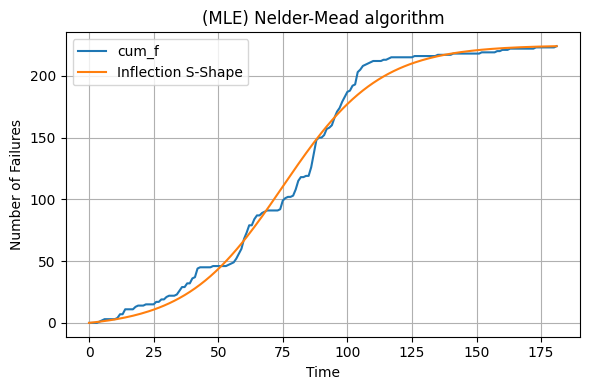

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) Nelder-Mead algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Powell algorithm

In [16]:
result = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='Powell', bounds=mle_bounds)

powell_b, powell_c = result.x
powell_a = inflection_s_a(t[-1], np.sum(f), powell_b, powell_c)
print(f'a: {powell_a}, b: {powell_b}, c: {powell_c}')

a: 224.7911008626943, b: 0.053431582817365764, c: 54.98465023716508


In [17]:
f_pred = inflection_s(t, powell_a, powell_b, powell_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 62.61067226991695
RMSE: 7.912690583481509
MAE: 5.8062320907339355
MAPE: 33851419419537.418
R2 score: 0.9915683373241688


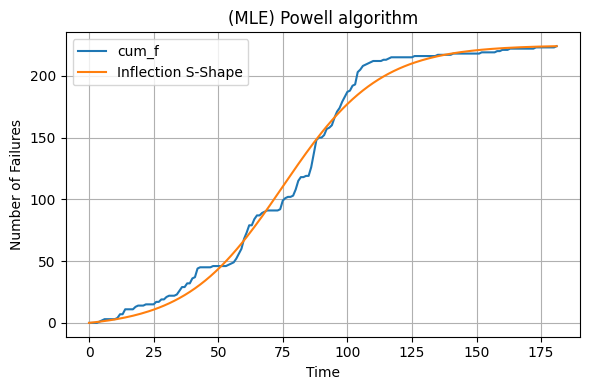

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) Powell algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### L-BFGS-B algorithm

In [19]:
result = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='L-BFGS-B', bounds=mle_bounds)

l_bfgs_b_b, l_bfgs_b_c = result.x
l_bfgs_b_a = inflection_s_a(t[-1], np.sum(f), l_bfgs_b_b, l_bfgs_b_c)
print(f'a: {l_bfgs_b_a}, b: {l_bfgs_b_b}, c: {l_bfgs_b_c}')

a: 370517780.0086902, b: 1.4901161193847656e-08, c: 3.461285796324897


In [20]:
f_pred = inflection_s(t, l_bfgs_b_a, l_bfgs_b_b, l_bfgs_b_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 1278.6896069908596
RMSE: 35.758769651525476
MAE: 27.337849020050722
MAPE: 183742136299017.3
R2 score: 0.8278012510908896


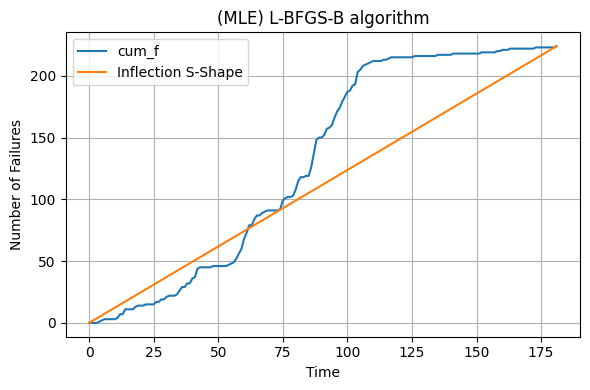

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) L-BFGS-B algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### truncated Newton (TNC) algorithm

In [22]:
reuslt = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='TNC', bounds=mle_bounds)

tnc_b, tnc_c = result.x
tnc_a = inflection_s_a(t[-1], np.sum(f), tnc_b, tnc_c)
print(f'a: {tnc_a}, b: {tnc_b}, c: {tnc_c}')

a: 370517780.0086902, b: 1.4901161193847656e-08, c: 3.461285796324897


In [23]:
f_pred = inflection_s(t, tnc_a, tnc_b, tnc_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 1278.6896069908596
RMSE: 35.758769651525476
MAE: 27.337849020050722
MAPE: 183742136299017.3
R2 score: 0.8278012510908896


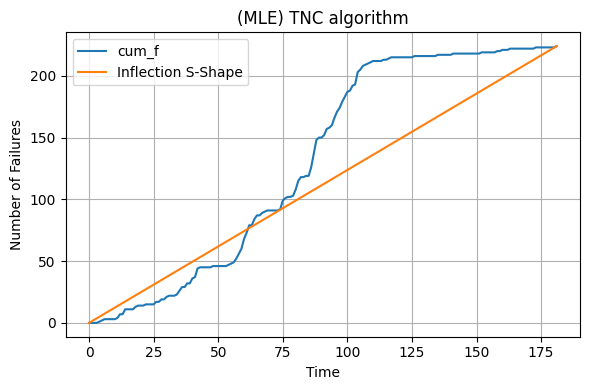

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) TNC algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Optimization BY Quadratic Approximations (COBYQA) algorithm

In [25]:
result = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='COBYQA', bounds=mle_bounds)

cobyqa_b, cobyqa_c = result.x
cobyqa_a = inflection_s_a(t[-1], np.sum(f), cobyqa_b, cobyqa_c)
print(f'a: {cobyqa_a}, b: {cobyqa_b}, c: {cobyqa_c}')

a: 224.79110011789749, b: 0.053431593813776684, c: 54.98470896546902


In [26]:
f_pred = inflection_s(t, cobyqa_a, cobyqa_b, cobyqa_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 62.610660512097645
RMSE: 7.912689840509208
MAE: 5.806232708862719
MAPE: 33851391278005.633
R2 score: 0.9915683389075725


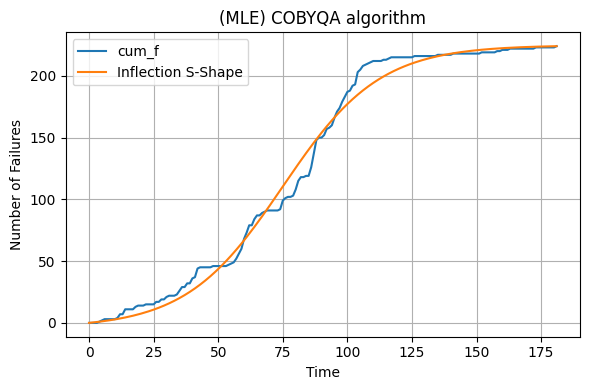

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) COBYQA algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Sequential Least Squares Programming (SLSQP)

In [28]:
result = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='SLSQP', bounds=mle_bounds)

slsqp_b, slsqp_c = result.x
slsqp_a = inflection_s_a(t[-1], np.sum(f), slsqp_b, slsqp_c)
print(f'a: {slsqp_a}, b: {slsqp_b}, c: {slsqp_c}')

a: 224.7908800785144, b: 0.05343460387878684, c: 54.99964061715919


In [29]:
f_pred = inflection_s(t, slsqp_a, slsqp_b, slsqp_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 62.60761999665752
RMSE: 7.912497709109148
MAE: 5.806379328756875
MAPE: 33844377649146.395
R2 score: 0.9915687483681265


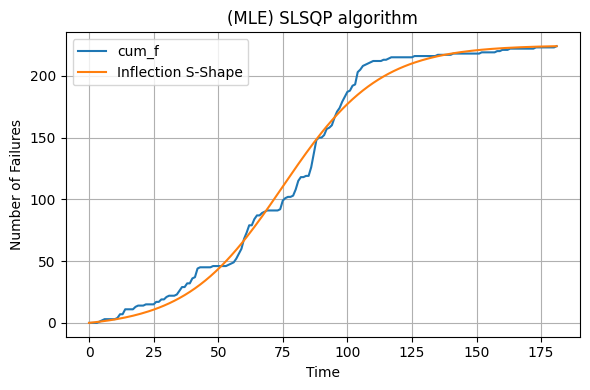

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) SLSQP algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Trust-Region algorithm

In [31]:
result = minimize(inflection_s_nll, mle_init_guess, args=(t, f),
                  method='trust-constr', bounds=mle_bounds)

trust_constr_b, trust_constr_c = result.x
trust_constr_a = inflection_s_a(t[-1], np.sum(f), trust_constr_b, trust_constr_c)
print(f'a: {trust_constr_a}, b: {trust_constr_b}, c: {trust_constr_c}')

a: 224.7911802802633, b: 0.05343045697551284, c: 54.97886135452262


In [32]:
f_pred = inflection_s(t, trust_constr_a, trust_constr_b, trust_constr_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 62.61184249977791
RMSE: 7.912764529529355
MAE: 5.806173201426231
MAPE: 33854166343812.406
R2 score: 0.991568179731492


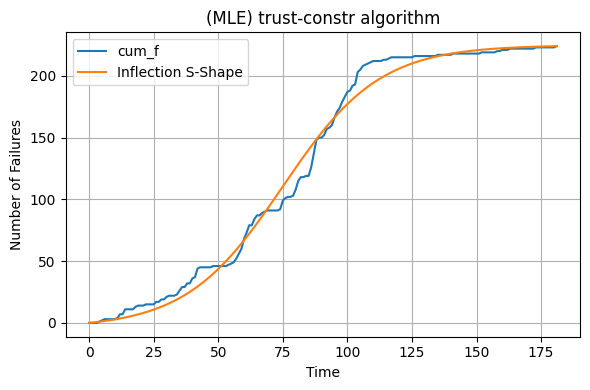

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Inflection S-Shape')

plt.title('(MLE) trust-constr algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()